In [ ]:
import tensorflow_decision_forests as tfdf

In [ ]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from img_utils import *
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)

In [ ]:
from utils import remove_outliers
from img_utils import preprocess_images

#Take only Copenhagen, and Ejerlejligheder
houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

#Remove theoutliers 
houses_df = remove_outliers(houses_df, 'price')

#Drop houses with no floorplan
houses_df = houses_df.dropna(subset=['image_floorplan'])

In [ ]:
import numpy as np
import pandas as pd
#Set the basement_size to 0 if it is NaN
houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

#Set the year_rebuilt to year_built if it is NaN
houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])

#Encode the features: postal_code, type, energy_class
houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
houses_df['type'] = houses_df['type'].astype('category').cat.codes
houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

#Drop Adress
houses_df = houses_df.drop(columns=['address'])

In [ ]:
from sklearn.model_selection import train_test_split

#DROP ANY NAN VALUES
houses_df = houses_df.dropna()
print("Number of Datapoints: ", len(houses_df))

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

Number of Datapoints:  272


# Feeding Vision Prediction into Random Forrest

In [ ]:
from keras.applications import VGG16
from keras.models import Model, load_model
from sklearn.ensemble import RandomForestRegressor
from utils import plot_regression_results, regression_stats
from multiprocessing import Process
import pandas as pd

def flatten_features(features):
    num_samples = features.shape[0]
    flattened_features = features.reshape(num_samples, -1)
    return flattened_features

def feature_extraction_vgg16(image_data):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    features = model.predict(image_data)
    return features

def feature_extraction_custom_model(image_data, model, layer_index):
    """Extract features from a custom model, based on a specified layer"""
    num_layers = len(model.layers)
    adjusted_index = num_layers - layer_index - 1
    print(f"Selected layer: {model.layers[adjusted_index].name}")
    
    features = model.layers[adjusted_index].output
    model = Model(inputs=model.inputs, outputs=features)
    features = model.predict(image_data)
    return features

def random_forest_prediction_with_feature_importance(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshold, use_model, use_custom_model=False, layer_index=0):
    if use_model:
        if use_custom_model:
            vision_model = load_model('VGG16_regression_model')
            print(vision_model.summary())
            train_features = feature_extraction_custom_model(preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), vision_model, layer_index)
            test_features = feature_extraction_custom_model(preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold), vision_model, layer_index)
        else:
            train_features = feature_extraction_vgg16(preprocess_images(train_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold))
            test_features = feature_extraction_vgg16(preprocess_images(test_df, 'image_floorplan', target_width, target_height, resize, gray_scale, threshold))

        print(f"Train features shape: {train_features.shape}")
        print(f"Test features shape: {test_features.shape}")
        
        train_features_flat = flatten_features(train_features)
        test_features_flat = flatten_features(test_features)
        
        train_features_df = pd.DataFrame(train_features_flat, index=train_df.index)
        test_features_df = pd.DataFrame(test_features_flat, index=test_df.index)

        # Name the new features
        feature_names = [f'vision_feature_{i}' for i in range(train_features_flat.shape[1])]
        train_features_df.columns = feature_names
        test_features_df.columns = feature_names
        
        train_df = pd.concat([train_df, train_features_df], axis=1)
        test_df = pd.concat([test_df, test_features_df], axis=1)

    # Setup Training Data
    x_train = train_df.drop(columns=['image_floorplan', 'price'])
    y_train = train_df['price']
    x_test = test_df.drop(columns=['image_floorplan', 'price'])
    y_test = test_df['price']
    
    # Train model with RandomForestRegressor
    forest = RandomForestRegressor(random_state=0)
    forest.fit(x_train, y_train)
    
    # Get feature importances
    feature_importances = forest.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    
    # Select top features
    num_selected_features = 100
    selected_feature_indices = sorted_indices[:num_selected_features]
    x_train_selected = x_train.iloc[:, selected_feature_indices]
    x_test_selected = x_test.iloc[:, selected_feature_indices]
    
    # Train model with selected features
    forest_selected = RandomForestRegressor(random_state=0)
    forest_selected.fit(x_train_selected, y_train)
    
    y_test_pred = forest_selected.predict(x_test_selected)

    regression_stats(y_test, y_test_pred)
    plot_regression_results('Random Forest Regression with Feature Importance', y_test, y_test_pred)

target_width = 500
target_height = 500
resize = True
gray_scale = False
threshhold = True
scale = False

2/2 [==============================] - 2s 608ms/step
postal_code 0.1492
type 0.0
size 0.5059
basement_size 0.0
rooms 0.0271
year_built 0.0644
year_rebuilt 0.0685
energy_label 0.0504
vision_model_prediction 0.1345
Mean Squared Error: 995436888950.909
Mean Absolute Error: 711748.1818181818
R^2: 0.7425171012318235


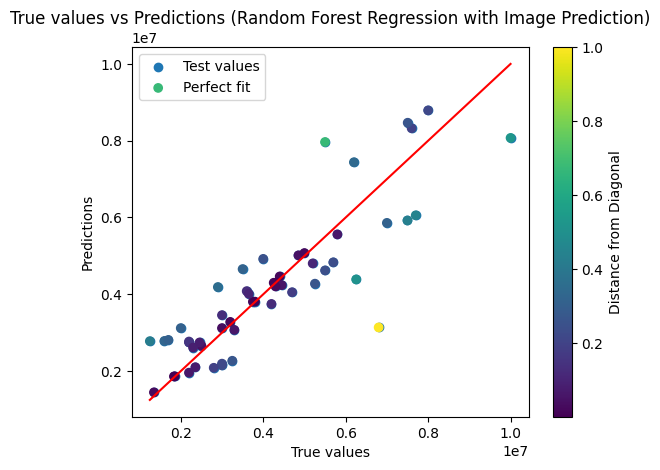

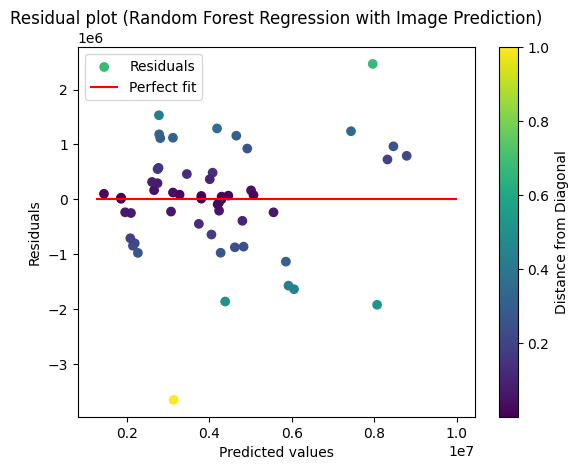

In [79]:
RF_with_vision_pred(mobilenet_model_5_label, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold)

2/2 [==============================] - 2s 666ms/step
postal_code 0.0301
type 0.0
size 0.0576
basement_size 0.0
rooms 0.0119
year_built 0.017
year_rebuilt 0.0199
energy_label 0.0141
vision_model_prediction 0.8494
Mean Squared Error: 3055569141533.636
Mean Absolute Error: 1251348.3636363635
R^2: 0.20963668447345551


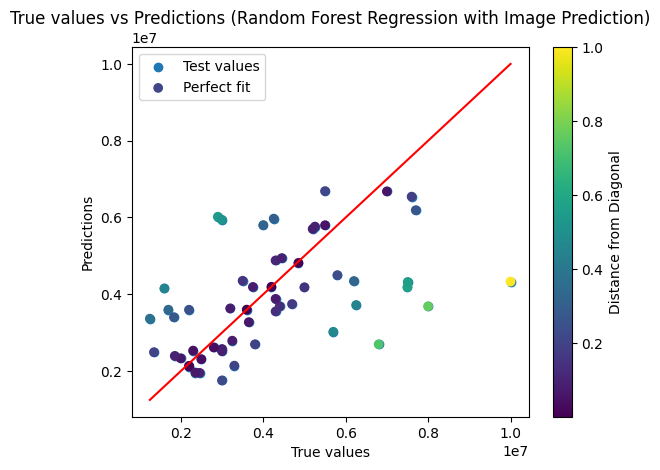

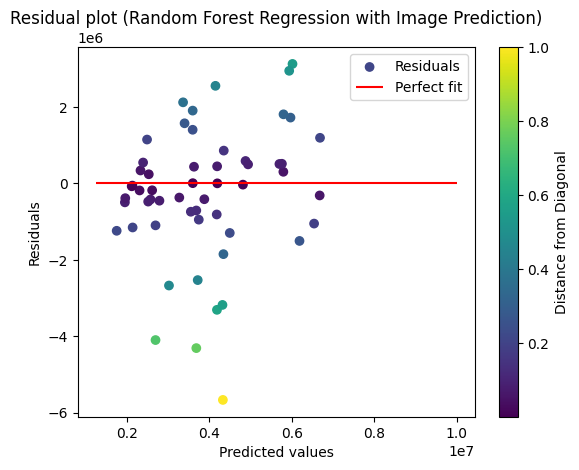

In [80]:
RF_with_vision_pred(mobilenet_model_continoues, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold)

# Vision and RF Combined 

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.models import Sequential
from sklearn.emsemble import RandomForestRegressor

In [ ]:
def comb_model(pretrained_vision_model, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold):

# No model
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, False))
p.start()
p.join()

# Base VGG16 model
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True))
p.start()
p.join()

# Transfer learned mode with layer index 0
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 0))
p.start()
p.join()

# Transfer learned mode with layer index 2
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 2))
p.start()
p.join()

# Transfer learned mode with layer index 4
p = Process(target=random_forest_prediction_with_feature_importance, args=(train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold, True, True, 4))
p.start()
p.join()


ValueError: The first argument to `Layer.call` must always be passed.